
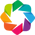

In [1]:
import matplotlib
import poloniex
import datetime
import holoviews as hv
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')

## Fetching and Visualizing data

In [13]:
import backtrader
import pandas as pd
# hv.notebook_extension('matplotlib')

Let's Download some OHLC series:

In [2]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=364)
ether = poloniex.get_ohlc('USDT_ETH',start, end)
btc = poloniex.get_ohlc('USDT_BTC', start,end)
ltc = poloniex.get_ohlc('USDT_LTC', start,end)

In [3]:
ether.describe()

close           high            low           open  \
count  104832.000000  104832.000000  104832.000000  104832.000000   
mean      291.436407     292.376644     290.424699     291.444194   
std       274.489100     275.539530     273.317996     274.489234   
min        10.366383      10.384485      10.350000      10.360000   
25%        64.344317      64.506255      64.165849      64.330152   
50%       278.934410     279.699230     278.000000     278.952792   
75%       332.000000     332.849795     331.110000     332.000000   
max      1422.470000    1424.000000    1417.000000    1421.215464   

         quoteVolume        volume  weightedAverage  
count  104832.000000  1.048320e+05    104832.000000  
mean      224.567764  5.451541e+04       291.399296  
std       457.009072  1.059030e+05       274.428264  
min         0.000000  0.000000e+00        10.359192  
25%        24.715164  3.939962e+03        64.329309  
50%        83.161101  1.895687e+04       278.829876  
75%       231.157527  5.964349e+04       332.011902  
max     13335.125868  2.635970e+06      1421.701388

In [4]:
def load_symbol(symbol, **kwargs):
    df = data[symbol]
    df.reset_index(level=0, inplace=True)
    return hv.Curve(df, ('date', 'Date'), ('close', 'Close price'))


data = {"ETH": ether, 'BTC':btc, 'LTC':ltc}
dmap = hv.DynamicMap(load_symbol, kdims='Symbol').redim.values(Symbol=list(data.keys()))

In [5]:
%%opts Curve [width=600] {+framewise}
dmap

:DynamicMap   [Symbol]

In [6]:
%%opts Scatter [width=600] (color='black')
smoothed = dmap*rolling(dmap, rolling_window=30)*rolling_outlier_std(dmap)
smoothed

:DynamicMap   [Symbol]

# Creating a strategy

From now on we are going to use the [backtrader](https://www.backtrader.com/docu/index.html) library to implent algirithmic strategies to trade Ether. 

In [9]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

In [10]:
def run_test():
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    res = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return res

In [35]:
class SMA_CrossOver(backtrader.Strategy):

    params = (('fast', 12), ('slow', 26))

    def __init__(self):
        self.rsi = btind.RSI()
        sma_fast = btind.SMA(period=self.p.fast)
        sma_slow = btind.SMA(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
            if (self.buysig < 0):
                self.sell()

            elif (self.buysig > 0):
                self.buy()
        else:
            self.buy()
#             if (self.rsi<=50):
#                 self.sell()

#         elif (self.rsi>=60):
#             self.buy()
            
class Aroon(backtrader.Strategy):
    params = (('period',70),)
    def __init__(self):
        self.a_up = btind.AroonUp(period=self.p.period)
        self.a_down = btind.AroonDown(period=self.p.period)
    def next(self):
        if self.position.size:
            if self.a_down >= 95:
                self.sell()
        elif self.a_up >=97:
            self.buy()

In [23]:
class DeltaStrat(backtrader.Strategy):
    def __init__(self):
        self.delta = 20
        self.price_in = None
        self.price_out = 100000
        self.trailing = 0.5
        self.target = 10000000
        self.order = None
        print(self.position.size)
        
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     self.price_out))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def next(self):
        self.price_out = self.data.close[0] if self.price_out is None else self.price_out
        for data in self.datas:
            curpos = self.getposition(data)
            if curpos.size:

                if self.data.close[0] - self.price_in >= self.delta:
                    size = curpos.size // 5 if curpos.size > 30 else curpos.size
                    self.order = self.sell(data=data, size=size)
                    self.price_out = self.data.close[0]

            if self.data.close[0] - self.price_out <= -self.delta:
                self.order = self.buy(data=data,
                                      exectype=bt.Order.Limit, 
                                      price=self.data.close[0] * 0.98)
                self.price_in = self.data.close[0]
            if curpos.size <= 30:
                self.order = self.buy(data=data,
                                      exectype=bt.Order.Limit, 
                                      price=self.data.close[0] * 0.98)
                self.price_in = self.data.close[0]

In [39]:
cerebro = backtrader.Cerebro()
cerebro.broker.setcash(100000.0)
data2 = backtrader.feeds.PandasData(dataname=ltc[:], datetime='date',)
cerebro.adddata(data2)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(backtrader.sizers.FixedSize, stake=30)
cerebro.addstrategy(SMA_CrossOver)
# cerebro.addstrategy(DeltaStrat)
cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
res = run_test()
print('Sharpe Ratio:', res[0].analyzers.mysharpe.get_analysis())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100784.27
Sharpe Ratio: OrderedDict([('sharperatio', -0.11884719725143612)])


<IPython.core.display.Javascript object>


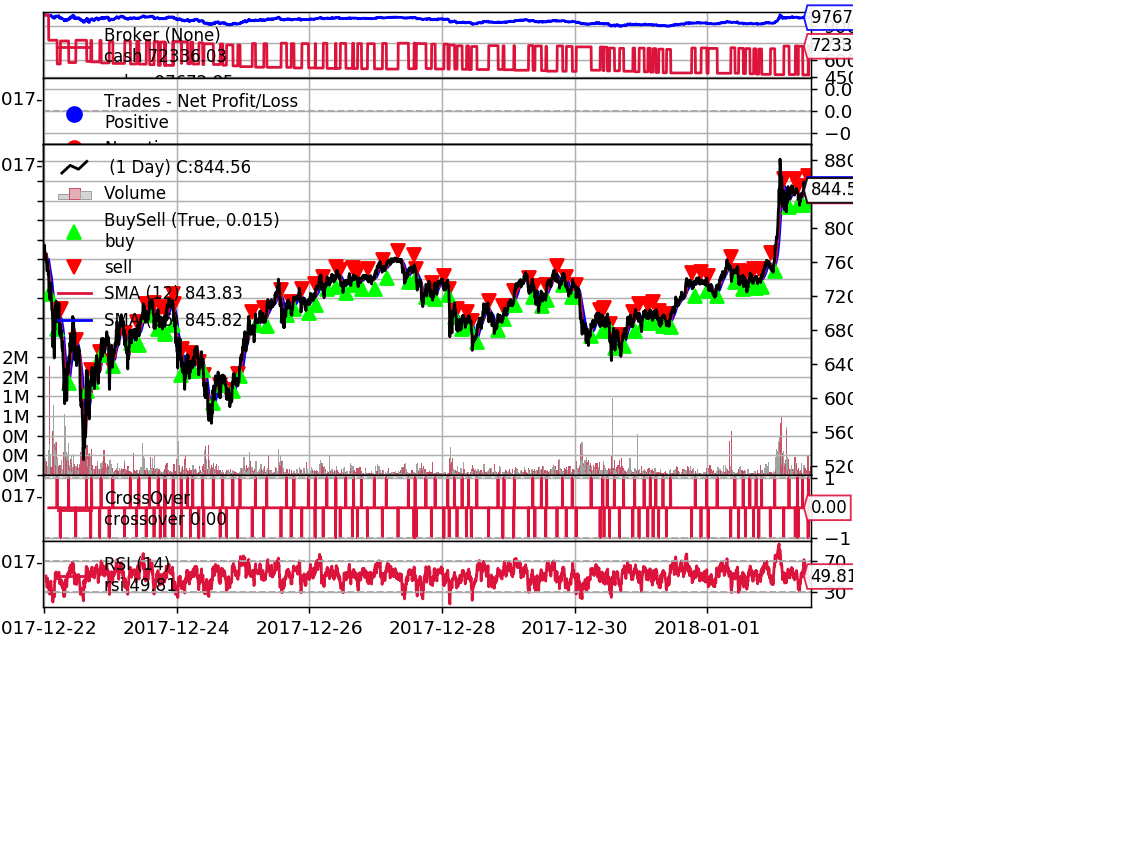

<IPython.core.display.Javascript object>


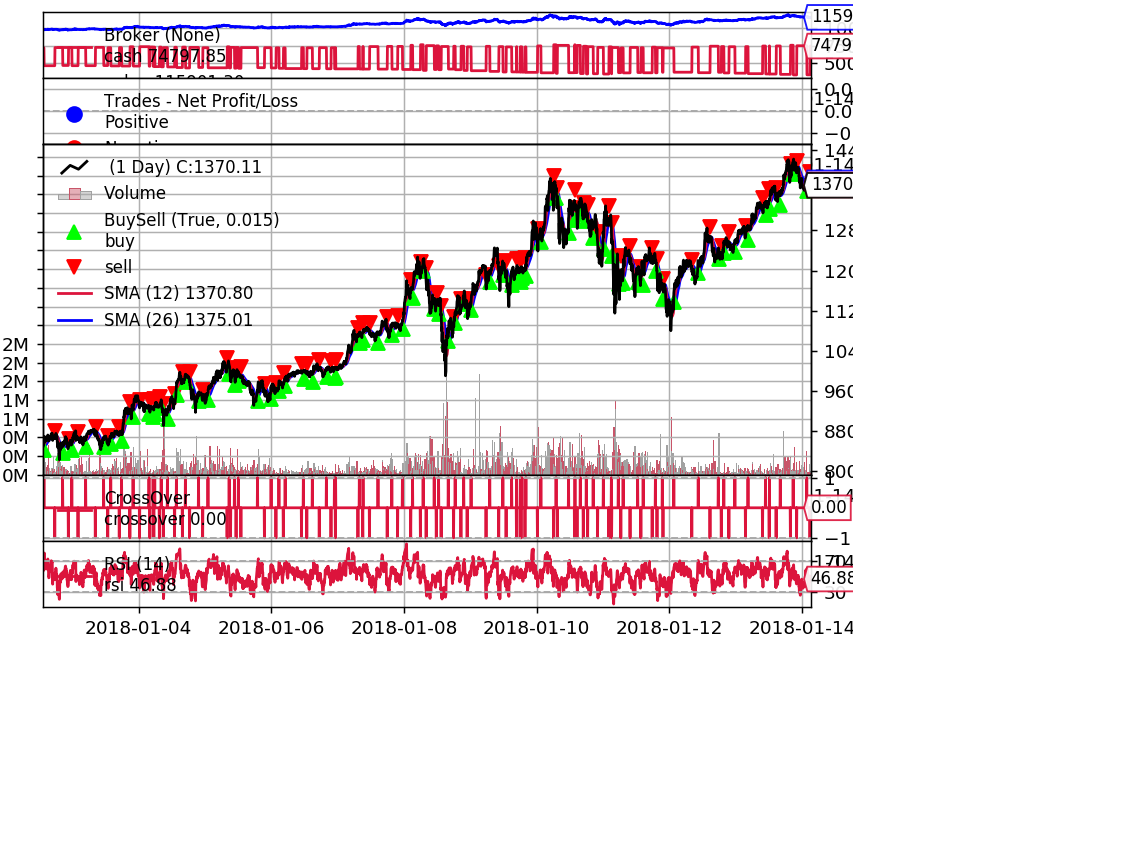

<IPython.core.display.Javascript object>


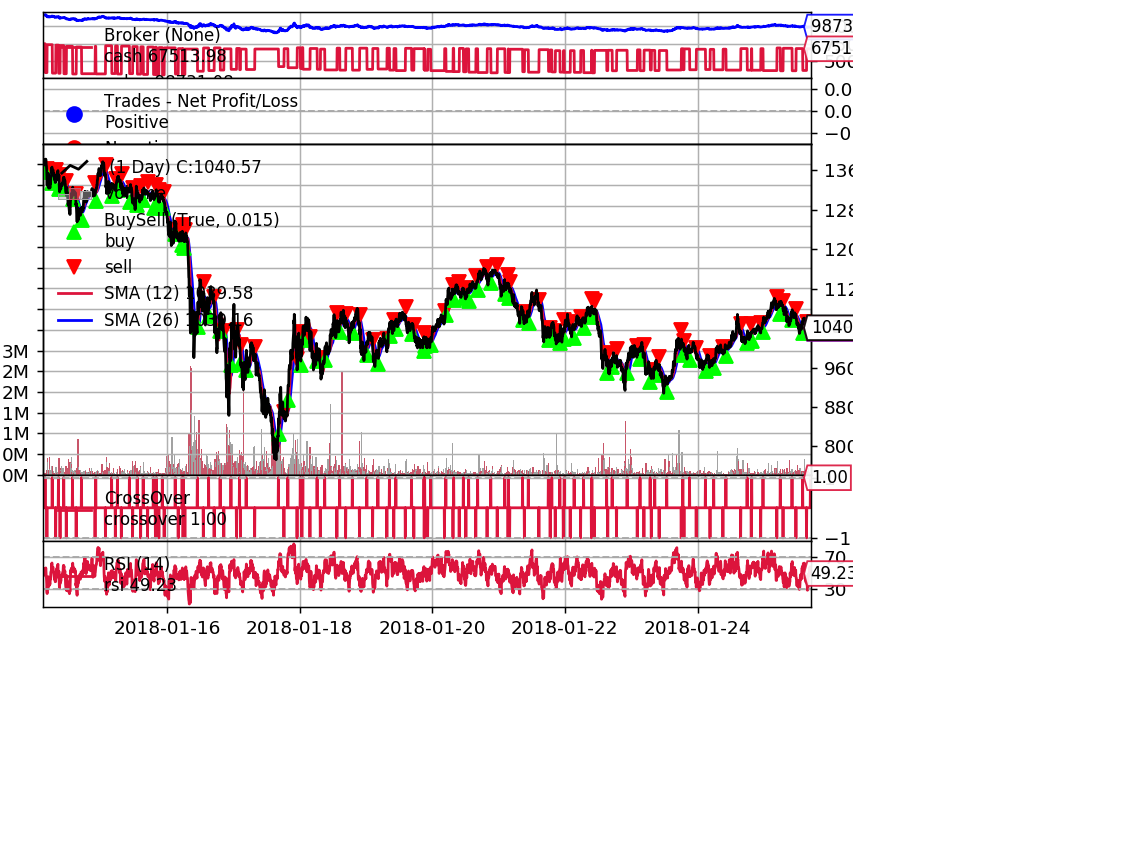

In [37]:
cerebro.plot(numfigs=3);

In [18]:
pyfoliozer = res[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [19]:
returns.plot()

In [20]:
import pyfolio as pf
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
     #gross_lev=gross_lev,
    live_start_date='2017-01-01',  # This date is sample specific
    round_trips=True
)


ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.6 or higher required)
NoneType: None
ERROR:theano.gpuarray:pygpu was configured but could not be imported or is too old (version 0.6 or higher required)
NoneType: None
/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


AttributeError: module 'empyrical.utils' has no attribute 'default_returns_func'